In [1]:
import numpy as np
import pandas as pd
import nltk
import re

import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import csv
random.seed(100)

from PIL import Image
from collections import Counter

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [3]:
if (nltk.download("punkt")):
    print("\"punkt\" is downloaded.")
## for stopwords
if (nltk.download('stopwords')):
    print("\"Stopwords\" are downloaded.")
## for lemmatization
if (nltk.download('wordnet')):
    print("Algorithm for lemmatization is downloaded.")  
    
if (nltk.download('vader_lexicon')):
    print("download vader lexicon")

"punkt" is downloaded.
"Stopwords" are downloaded.
Algorithm for lemmatization is downloaded.
download vader lexicon


[nltk_data] Downloading package punkt to /Users/amayaqing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amayaqing/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amayaqing/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amayaqing/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Read and Process Data

In [4]:
train_data = pd.read_csv("data/train.tsv", sep='\t', header=None)
test_data = pd.read_csv("data/test.tsv", sep='\t', header=None)
valid_data = pd.read_csv("data/valid.tsv", sep='\t', header=None)

train_text = train_data[2]
test_text = test_data[2]
valid_text = valid_data[2]

len(train_text), len(test_text), len(valid_text)

(10240, 1267, 1284)

In [5]:
def textclean(t):
    '''
    This function cleans the tweets.
    '''
    t = t.lower() # convert to lowercase
    t = re.sub('\\\\u[0-9A-Fa-f]{4}','', t) # remove NON- ASCII characters
    t = re.sub("[0-9]", "", t) # remove numbers # re.sub("\d+", "", t)
    t = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', t) # remove punctuations
    
    return t

In [6]:
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
stemmer = PorterStemmer()

In [7]:
def preprocess(t):
    
    # tokenization
    tw = []
    tw = word_tokenize(t)
    
    # remove the stopwords
    fs = []
    fs = ([i for i in tw if i not in stop_words])
    
    # stemming
    # remove the inflectional forms of a word 
    # and bring them to a base form called the stem
    ss = [stemmer.stem(i) for i in fs]
    
    # lemmatization
    # convert a word to its meaningful base form
    ns = []
    for i in ss:
        ns.append(lem.lemmatize(i, 'v'))
    ns = ' '.join(ns)
    
    return ns

In [8]:
train_cleaned = [textclean(t) for t in train_text]
train_pp = [preprocess(t) for t in train_cleaned]

test_cleaned = [textclean(t) for t in test_text]
test_pp = [preprocess(t) for t in test_cleaned]

valid_cleaned = [textclean(t) for t in valid_text]
valid_pp = [preprocess(t) for t in valid_cleaned]

print("Before: ", train_text[0])
print("After: ", train_pp[0])

Before:  Says the Annies List political group supports third-trimester abortions on demand.
After:  say anni list polit group support thirdtrimest abort demand


## Write into file

In [9]:
train_data[2] = train_pp
test_data[2] = test_pp
valid_data[2] = valid_pp

train_data.to_csv('train_cleaned.csv', index = False, encoding='utf-8', header=None)
test_data.to_csv('test_cleaned.csv', index = False, encoding='utf-8', header=None)
valid_data.to_csv('valid_cleaned.csv', index = False, encoding='utf-8', header=None)

## Build document vectors

In [9]:
# vectorize
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=None)

trainX = cntvect.fit_transform(train_pp)
testX  = cntvect.transform(test_pp)
validX = cntvect.transform(valid_pp)

trainY = train_data[1]
testY = test_data[1]
validY = valid_data[1]

print("vocbulary size: {}".format(len(cntvect.vocabulary_)))

vocbulary size: 8265


In [10]:
# TF-IDF representation
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')

trainXtf = tf_trans.fit_transform(trainX)
testXtf = tf_trans.transform(testX)

## Word Cloud

In [11]:
words_true = []
words_fake = []
true = {'TRUE', 'mostly-true'}
fake = {'FALSE', 'barely-true'}

for i in range(len(train_pp)): 
    if train_data[1][i] in true:
        for w in word_tokenize(train_pp[i]):
            words_true.append(w)
    elif train_data[1][i] in fake:
        for w in word_tokenize(train_pp[i]):
            words_fake.append(w)

for i in range(len(test_pp)): 
    if test_data[1][i] in true:
        for w in word_tokenize(test_pp[i]):
            words_true.append(w)
    elif test_data[1][i] in fake:
        for w in word_tokenize(test_pp[i]):
            words_fake.append(w)
        
for i in range(len(valid_pp)): 
    if valid_data[1][i] in true:
        for w in word_tokenize(valid_pp[i]):
            words_true.append(w)
    elif valid_data[1][i] in fake:
        for w in word_tokenize(valid_pp[i]):
            words_fake.append(w)

In [12]:
from nltk.probability import FreqDist
freq_true = FreqDist(words_true)
fdict = {}
for k, v in freq_true.items():
    fdict[k] = v
fdict = sorted(fdict.items(), key=lambda kv: kv[1], reverse=True)

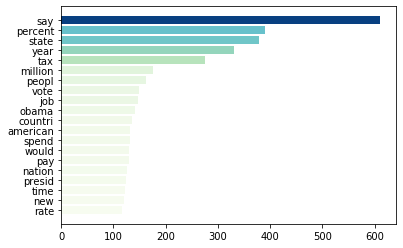

In [13]:
from matplotlib import cm

topfreq = fdict[:20]
x = [topfreq[i][0] for i in range(len(topfreq))]
y = [topfreq[i][1] for i in range(len(topfreq))]
x.reverse()
y.reverse()

map_vir = cm.get_cmap(name='GnBu')
norm = plt.Normalize(min(y), max(y))
color = map_vir(norm(y))

#plt.barh(x, y, color = (0.5,0.1,0.5,0.6))
plt.barh(x, y, color = color)
plt.savefig("fig/word_count_true.png", dpi=300)
plt.show()


In [14]:
freq_fake = FreqDist(words_fake)
fdict = {}
for k, v in freq_fake.items():
    fdict[k] = v
fdict = sorted(fdict.items(), key=lambda kv: kv[1], reverse=True)

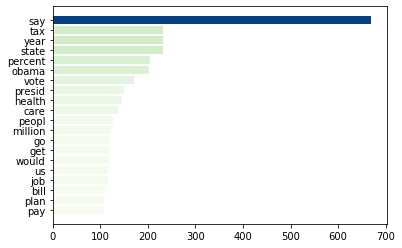

In [15]:
topfreq = fdict[:20]
x = [topfreq[i][0] for i in range(len(topfreq))]
y = [topfreq[i][1] for i in range(len(topfreq))]
x.reverse()
y.reverse()

map_vir = cm.get_cmap(name='GnBu')
norm = plt.Normalize(min(y), max(y))
color = map_vir(norm(y))

#plt.barh(x, y, color = (0.5,0.1,0.5,0.6))
plt.barh(x, y, color = color)
plt.savefig("fig/word_count_fake.png", dpi=300)
plt.show()



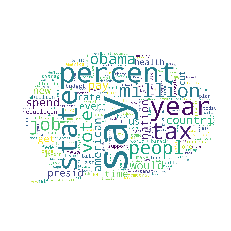

In [16]:
from wordcloud import WordCloud

mask = np.array(Image.open("comment.png"))

wc = WordCloud(
    max_words=200,
    background_color = 'white',
    mask = mask,
    width=2000, 
    height=1200
)

word_cloud = wc.generate_from_frequencies(freq_true)
word_cloud.background_color = 'white'
plt.imshow(word_cloud)
plt.axis("off")
plt.savefig("fig/cloud_true.png", dpi=300)
plt.show()

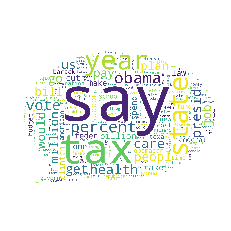

In [17]:
word_cloud = wc.generate_from_frequencies(freq_fake)
word_cloud.background_color = 'white'
plt.imshow(word_cloud)
plt.axis("off")
plt.savefig("fig/cloud_fake.png", dpi=300)
plt.show()

## Sentiment Analysis (VADER)

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [24]:
sia = SentimentIntensityAnalyzer()
text = train_text[0]
res = sia.polarity_scores(text)
res = sorted(res.items(), key=lambda kv: kv[1], reverse=True)
res[0][0]

'neu'

In [25]:
sentiment_true, sentiment_fake = [], []

for i in range(len(train_text)):
    res = sia.polarity_scores(train_text[i])
    res = sorted(res.items(), key=lambda kv: kv[1], reverse=True)
    if train_data[1][i] in true:
        sentiment_true.append(res[0][0])
    elif train_data[1][i] in fake:
        sentiment_fake.append(res[0][0])
    
for i in range(len(valid_text)):
    res = sia.polarity_scores(valid_text[i])
    res = sorted(res.items(), key=lambda kv: kv[1], reverse=True)
    if valid_data[1][i] in true:
        sentiment_true.append(res[0][0])
    elif valid_data[1][i] in fake:
        sentiment_fake.append(res[0][0])

for i in range(len(test_text)):
    res = sia.polarity_scores(test_text[i])
    res = sorted(res.items(), key=lambda kv: kv[1], reverse=True)
    if test_data[1][i] in true:
        sentiment_true.append(res[0][0])
    elif test_data[1][i] in fake:
        sentiment_fake.append(res[0][0])

In [26]:
count = Counter(sentiment_true)
names, size = [], []
for k, v in count.items():
    names.append(k)
    size.append(v)
count

Counter({'neu': 2288, 'compound': 93, 'neg': 68, 'pos': 5})

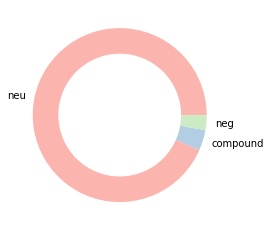

In [29]:
my_circle = plt.Circle( (0,0), 0.7, color='white')

from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(size[:3], labels=names[:3], colors=Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("fig/sentiment_true.png", dpi=300)
plt.show()

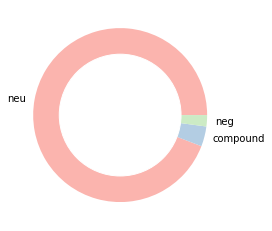

(None, Counter({'neu': 1974, 'compound': 78, 'neg': 44, 'pos': 7}))

In [30]:
count = Counter(sentiment_fake)
names, size = [], []
for k, v in count.items():
    names.append(k)
    size.append(v)

my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(size[:3], labels=names[:3], colors=Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("fig/sentiment_false.png", dpi=300)
plt.show(), count

## Model

In [31]:
# vectorize
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=None)

trainX = cntvect.fit_transform(train_pp)
testX  = cntvect.transform(test_pp)
validX = cntvect.transform(valid_pp)

trainY = train_data[1]
testY = test_data[1]
validY = valid_data[1]

print("vocbulary size: {}".format(len(cntvect.vocabulary_)))

vocbulary size: 8265


In [32]:
# TF-IDF representation
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')

trainXtf = tf_trans.fit_transform(trainX)
testXtf = tf_trans.transform(testX)

In [33]:
# Plot confusion matrix
import seaborn as sn
classes = ['TRUE', 'mostly-true', 'half-true', 'barely-true', 'FALSE']

def plot_conf_matrix(test_labels, pred_labels):
    CM = confusion_matrix(test_labels, pred_labels)
    ax = plt.axes()
    sn.heatmap(CM, annot=True, 
               xticklabels=classes, 
               yticklabels=classes, ax = ax, fmt='d')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.xlim(-0.1, len(classes))
    plt.ylim(-0.1, len(classes))
    plt.savefig('cm.png', pmi=300)

### Naive Bayes Classifiers

In [35]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

#### Bernoulli Naive Bayes

In [36]:
parameters = {'alpha': arange(0, 0.1, 0.0001)}
bmodel = naive_bayes.BernoulliNB()

bmodel_cv = GridSearchCV(bmodel, parameters, cv=5, n_jobs=-1)
bmodel_cv.fit(trainX, trainY)
bmodel_best = bmodel_cv.best_estimator_

In [37]:
predYtrain = bmodel_best.predict(trainX)
acc_train = metrics.accuracy_score(trainY, predYtrain)

predYtest = bmodel_best.predict(testX)
acc_test = metrics.accuracy_score(testY, predYtest)

print("train accuracy: ", acc_train)
print("test accuracy: ", acc_test)

train accuracy:  0.6873046875
test accuracy:  0.23993685872138912


<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)



Confusion Matrix:
  [[42 53 45 34 14 24]
 [36 55 53 46 15 44]
 [37 40 76 59 16 37]
 [23 37 46 72  6 57]
 [13 23 17 14 15 10]
 [20 42 41 49 12 44]]

Report :                precision    recall  f1-score   support

 barely-true       0.25      0.20      0.22       212
       false       0.22      0.22      0.22       249
   half-true       0.27      0.29      0.28       265
 mostly-true       0.26      0.30      0.28       241
  pants-fire       0.19      0.16      0.18        92
        true       0.20      0.21      0.21       208

    accuracy                           0.24      1267
   macro avg       0.23      0.23      0.23      1267
weighted avg       0.24      0.24      0.24      1267



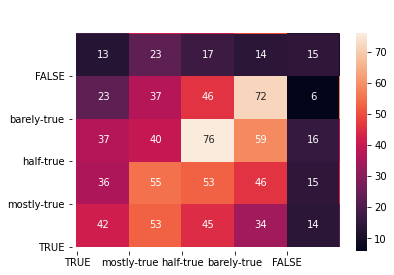

In [43]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

In [40]:
!pip install matplotlab==3.0.3

ERROR: Could not find a version that satisfies the requirement matplotlab==3.0.3
ERROR: No matching distribution found for matplotlab==3.0.3


#### Muliomial Naive Bayes

In [41]:
parameters = {'alpha': arange(0, 0.1, 0.0001)}
mmodel_tf = naive_bayes.MultinomialNB()

mmodel_tf_cv = GridSearchCV(mmodel_tf, parameters)
mmodel_tf_cv.fit(trainX, trainY)
mmodel_tf_best = mmodel_tf_cv.best_estimator_

/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:508: UserWarnin

In [42]:
mmodel_tf_cv.best_params_

{'alpha': 0.09290000000000001}

In [44]:
predYtrain = mmodel_tf_best.predict(trainX)
acc_train = metrics.accuracy_score(trainY, predYtrain)

predYtest = mmodel_tf_best.predict(testX)
acc_test = metrics.accuracy_score(testY, predYtest)

print("train accuracy: ", acc_train)
print("test accuracy: ", acc_test)

train accuracy:  0.6802734375
test accuracy:  0.23283346487766376


<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)



Confusion Matrix:
  [[35 50 51 34 16 26]
 [39 46 58 51 18 37]
 [41 38 80 61 15 30]
 [25 35 51 71  6 53]
 [14 19 16 17 15 11]
 [24 36 37 49 14 48]]

Report :                precision    recall  f1-score   support

 barely-true       0.20      0.17      0.18       212
       false       0.21      0.18      0.19       249
   half-true       0.27      0.30      0.29       265
 mostly-true       0.25      0.29      0.27       241
  pants-fire       0.18      0.16      0.17        92
        true       0.23      0.23      0.23       208

    accuracy                           0.23      1267
   macro avg       0.22      0.22      0.22      1267
weighted avg       0.23      0.23      0.23      1267



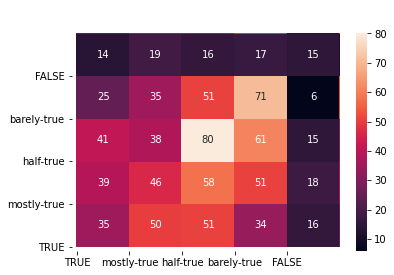

In [45]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

### Logistic Regression

In [46]:
logreg = linear_model.LogisticRegressionCV(cv=5, random_state=0).fit(trainXtf, trainY)

print("best C parameter: ", logreg.C_[0])

/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

best C parameter:  2.782559402207126


In [47]:
predYtrain = logreg.predict(trainXtf)
acc_train = metrics.accuracy_score(trainY, predYtrain)

predYtest = logreg.predict(testXtf)
acc_test = metrics.accuracy_score(testY, predYtest)

print("train accuracy: ", acc_train)
print("test accuracy: ", acc_test)

train accuracy:  0.49951171875
test accuracy:  0.23125493291239146


<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)



Confusion Matrix:
  [[22 67 74 31  0 18]
 [23 85 74 47  0 20]
 [25 61 86 68  0 25]
 [14 47 73 67  0 40]
 [13 33 29  8  1  8]
 [13 53 55 52  3 32]]

Report :                precision    recall  f1-score   support

 barely-true       0.20      0.10      0.14       212
       false       0.25      0.34      0.29       249
   half-true       0.22      0.32      0.26       265
 mostly-true       0.25      0.28      0.26       241
  pants-fire       0.25      0.01      0.02        92
        true       0.22      0.15      0.18       208

    accuracy                           0.23      1267
   macro avg       0.23      0.20      0.19      1267
weighted avg       0.23      0.23      0.21      1267



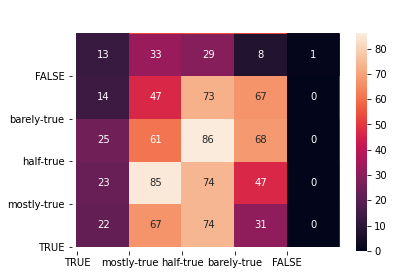

In [48]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

### AdaBoost

In [49]:
paramgrid = {'n_estimators': [10, 50, 100, 1000] }

adaclf = ensemble.AdaBoostClassifier(random_state=5489, algorithm='SAMME')
adacv = model_selection.GridSearchCV(adaclf, param_grid=paramgrid, cv=5, n_jobs=-1)
adacv.fit(trainXtf, trainY)
adacv.best_score_

0.22001953125

In [55]:
predYtrain = adacv.best_estimator_.predict(trainXtf)
acc_train = metrics.accuracy_score(trainY, predYtrain)

predYtest = adacv.best_estimator_.predict(testXtf)
acc_test = metrics.accuracy_score(testY, predYtest)

print("train accuracy: ", acc_train)
print("test accuracy: ", acc_test)

train accuracy:  0.24326171875
test accuracy:  0.2280978689818469


<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)



Confusion Matrix:
  [[  4 126  46  29   0   7]
 [  3 158  40  42   0   6]
 [  6 137  56  53   0  13]
 [  2 107  65  55   0  12]
 [  0  59  20  11   1   1]
 [  1 102  40  50   0  15]]

Report :                precision    recall  f1-score   support

 barely-true       0.25      0.02      0.04       212
       false       0.23      0.63      0.34       249
   half-true       0.21      0.21      0.21       265
 mostly-true       0.23      0.23      0.23       241
  pants-fire       1.00      0.01      0.02        92
        true       0.28      0.07      0.11       208

    accuracy                           0.23      1267
   macro avg       0.37      0.20      0.16      1267
weighted avg       0.29      0.23      0.18      1267



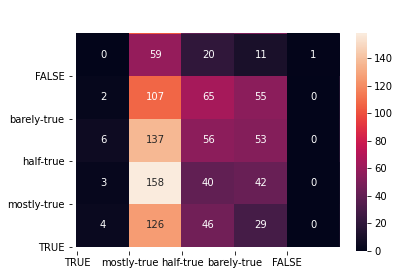

In [56]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

### Random Forest

In [57]:
paramgrid = {'n_estimators': range(50, 501, 50)}
rf = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1, )

rfcv = model_selection.GridSearchCV(rf, param_grid=paramgrid, cv=5, n_jobs=-1)
rfcv.fit(trainXtf, trainY)
rfcv.best_score_

0.24921875

In [58]:
rfcv.best_params_

{'n_estimators': 500}

In [59]:
predYtrain = rfcv.best_estimator_.predict(trainXtf)
acc_train = metrics.accuracy_score(trainY, predYtrain)

predYtest = rfcv.best_estimator_.predict(testXtf)
acc_test = metrics.accuracy_score(testY, predYtest)

print("train accuracy: ", acc_train)
print("test accuracy: ", acc_test)

train accuracy:  0.99921875
test accuracy:  0.24388318863456984



Confusion Matrix:
  [[32 68 51 42  1 18]
 [22 96 63 49  2 17]
 [22 75 75 69  1 23]
 [16 64 59 68  2 32]
 [15 40 16 11  4  6]
 [11 62 37 60  4 34]]

Report :                precision    recall  f1-score   support

 barely-true       0.27      0.15      0.19       212
       false       0.24      0.39      0.29       249
   half-true       0.25      0.28      0.27       265
 mostly-true       0.23      0.28      0.25       241
  pants-fire       0.29      0.04      0.08        92
        true       0.26      0.16      0.20       208

    accuracy                           0.24      1267
   macro avg       0.26      0.22      0.21      1267
weighted avg       0.25      0.24      0.23      1267



<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)


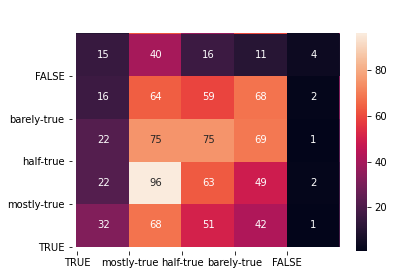

In [60]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

In [ ]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

### SVM

In [61]:
# SVM
exps = {
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf', class_weight='balanced') },
#     'svm-poly': {
#         'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
#         'clf': svm.SVC(kernel='poly', class_weight='balanced') },
    }

In [62]:
clfs = {}

for k, v in exps.items():
    cv = model_selection.GridSearchCV(v['clf'], param_grid=v['paramgrid'], cv=5, n_jobs=-1)
    cv.fit(trainXtf, trainY)
    clfs[k] = cv
    
    print("{}: ".format(k))
    print(clfs[k].best_score_)
    print(clfs[k].best_params_)

svm-rbf: 
0.25146484375
{'C': 1.6681005372000592, 'gamma': 4.641588833612782}


In [63]:
### INSERT YOUR CODE HERE
for k, v in clfs.items():
    predYtrain = v.best_estimator_.predict(trainXtf)
    acc_train = metrics.accuracy_score(trainY, predYtrain)

    predYtest = v.best_estimator_.predict(testXtf)
    acc_test = metrics.accuracy_score(testY, predYtest)
    
    print("train accuracy: ", acc_train)
    print("test accuracy: ", acc_test)

train accuracy:  0.87900390625
test accuracy:  0.24230465666929754


<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)



Confusion Matrix:
  [[52 41 45 27 17 30]
 [49 60 46 39 15 40]
 [51 47 70 50 15 32]
 [33 32 52 58 11 55]
 [18 22 15 11 16 10]
 [24 37 42 42 12 51]]

Report :                precision    recall  f1-score   support

 barely-true       0.23      0.25      0.24       212
       false       0.25      0.24      0.25       249
   half-true       0.26      0.26      0.26       265
 mostly-true       0.26      0.24      0.25       241
  pants-fire       0.19      0.17      0.18        92
        true       0.23      0.25      0.24       208

    accuracy                           0.24      1267
   macro avg       0.24      0.24      0.24      1267
weighted avg       0.24      0.24      0.24      1267



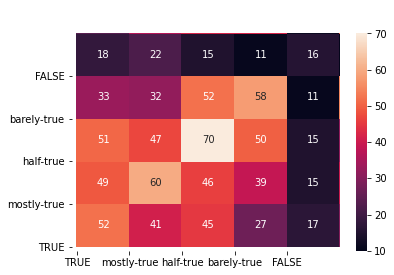

In [64]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))

### Ensemble

In [65]:
# Ensemble
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

In [66]:
clf1 = RandomForestClassifier(n_estimators=500, random_state=1)
clf2 = svm.SVC(kernel='rbf', C=1.6681005372000592, gamma=4.641588833612782)
clf3 = LogisticRegression(C=2.782559402207126)


eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('svm', clf2), ('lr', clf3)], voting='hard')

eclf = eclf.fit(trainXtf, trainY)

/home/kyrie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
predYtrain = eclf.predict(trainXtf)
acc_train = metrics.accuracy_score(trainY, predYtrain)

predYtest = eclf.predict(testXtf)
acc_test = metrics.accuracy_score(testY, predYtest)

print("train accuracy: ", acc_train)
print("test accuracy: ", acc_test)

train accuracy:  0.88583984375
test accuracy:  0.23914759273875297



Confusion Matrix:
  [[35 68 60 32  0 17]
 [33 90 65 45  0 16]
 [43 67 81 54  0 20]
 [17 50 70 64  0 40]
 [14 36 23  9  4  6]
 [19 54 55 48  3 29]]

Report :                precision    recall  f1-score   support

 barely-true       0.22      0.17      0.19       212
       false       0.25      0.36      0.29       249
   half-true       0.23      0.31      0.26       265
 mostly-true       0.25      0.27      0.26       241
  pants-fire       0.57      0.04      0.08        92
        true       0.23      0.14      0.17       208

    accuracy                           0.24      1267
   macro avg       0.29      0.21      0.21      1267
weighted avg       0.26      0.24      0.23      1267



<ipython-input-33-03e12b627578>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pmi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('cm.png', pmi=300)


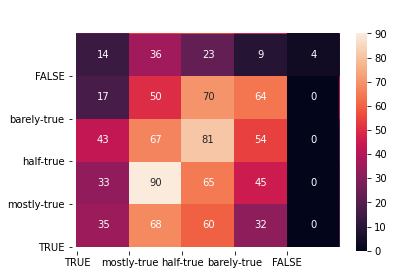

In [68]:
plot_conf_matrix(testY, predYtest)

print("\nConfusion Matrix:\n ", 
        confusion_matrix(testY, predYtest))

print("\nReport : ", 
        classification_report(testY, predYtest))